In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import datetime as dt
import json

## 퀀트함수
from quant_functions import anal_funcs, data_funcs
import portfolio_obtimizer
import myfuncs
from fredapi import Fred
fred = Fred(api_key='cfb4f49f5c1a9396f671b8049d992e56')

# 시각화 관련
import plotly_express as px
import plotly.figure_factory as ff
import cufflinks as cf
cf.go_offline(connected=True)
## cf.getThemes()
cf.set_config_file(theme='polar')
import plotly.graph_objects as go
import seaborn as sns
sns.set_style('whitegrid')
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mticker
from matplotlib.ticker import LogLocator
import matplotlib.pyplot as plt
## figure size 설정
figsize=(12, 8)
plt.rcParams["figure.figsize"] = figsize
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

import graphModule as gm

## color 설정
with open('colors.json') as f:
    mycolors = json.load(f)

# 블루 테마
cmap_colors = ["#FFFFFF", mycolors['color_cont3'], mycolors['color_cont2']]
# LinearSegmentedColormap 생성
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", cmap_colors, N=256)    

## shock case
with open('shockCase.json', encoding='utf-8') as f:
    shock_cases = json.load(f)

## Data Load

In [2]:
## 보간용 필수 데이터
gold = pd.read_csv(f"gold.csv", encoding='utf-8').set_index('Date')[['Close']].rename(columns={'Close':'Gold'})
gold.index = pd.to_datetime(gold.index)
div = pd.read_csv(f"div.csv", encoding='utf-8').set_index('Date')[['Close']].rename(columns={'Close':'Div'})
div.index = pd.to_datetime(div.index)
ds20 = fred.get_series('DGS20')
ds10 = fred.get_series('DGS10')

## load data
df_ref = data_funcs.get_merged_df('^IXIC', '^GSPC', '^DJI', 'GC=F')
df_ref = df_ref.fillna(method = 'pad')
df_ref['Div'] = div['Div']
df_ref['Gold'] = gold['Gold']
df_ref['DGS10'] = ds10
df_ref['DGS20'] = ds20

## Imputation
df_ref = myfuncs.imputation(df_ref, '^GSPC', '^DJI')
df_ref = myfuncs.imputation(df_ref, '^DJI', 'Div')
df_ref = myfuncs.imputation(df_ref, 'DGS10', 'DGS20')
df_ref = myfuncs.imputation(df_ref, 'DGS20', 'DGS10')
df_ref = myfuncs.imputation(df_ref, 'GC=F', 'Gold')
df_ref['Gold']['1975-01-02'] = 1
df_ref['Gold']['1975-01-03'] = 1

## column selection
df_ref = df_ref[['^GSPC', '^DJI', '^IXIC', 'Div', 'DGS10', 'DGS20', 'Gold']]
df_ref.columns = ['S&P500', 'DowJones', 'NASDAQ', 'Div', 'DGS10', 'DGS20', 'Gold']

## 75년 이전에는 Gold 데이터가 없음
df_ref = df_ref['1975':]
df_ref = df_ref/df_ref.iloc[0]

[*********************100%%**********************]  4 of 4 completed

0.9188454372299749
0.8698779253276527
0.7566389496342977
1.1913286823587577
0.9953424146502148


In [3]:
## 프로젝트마다 필요한 데이터
tickers = ['QQQ', 'SPY', 'TQQQ', 'TLT']
df_ori = data_funcs.get_merged_df(*tickers)
df_ori = df_ori[tickers]

[*********************100%%**********************]  4 of 4 completed


In [4]:
## 보간 시계열 데이터
df_imp = pd.concat([df_ref, df_ori], axis=1)
df_imp = myfuncs.imputation(df_imp, 'NASDAQ', 'QQQ')
df_imp = myfuncs.imputation(df_imp, 'S&P500', 'SPY')
df_imp = myfuncs.imputation(df_imp, 'QQQ', 'TQQQ')
df_imp = myfuncs.imputation(df_imp, 'DGS20', 'TLT')


## 비보간 시계열 데이터
df_cut = df_ori.dropna()
df_cut = df_cut/df_cut.iloc[0]

1.0448661173510772
0.9936330266825417
2.9806808492247416
-0.4193974664549246


## Data Selection

In [5]:
## assets = ['JEPQ', 'QQQ']
assets = ['TQQQ', 'QQQ']

In [6]:
plot_df = df_imp.copy()
# plot_df = df_imp['1999':].copy()
# plot_df = df_imp['1999':'2007'].copy()
# plot_df = df_imp['2007':].copy()
# plot_df = df_imp['2015':].copy()
# plot_df = df_cut[:]
plot_df = plot_df/plot_df.iloc[0]
highlight_periods = [(shock_cases['1차오일쇼크_t0'], shock_cases['1차오일쇼크_t1']),
                     (shock_cases['2차오일쇼크_t0'], shock_cases['2차오일쇼크_t1']),
                     (shock_cases['물가충격_t0'], shock_cases['물가충격_t1']),
                     (shock_cases['걸프전_t0'], shock_cases['걸프전_t1']),
                     (shock_cases['닷컴버블_t0'], shock_cases['닷컴버블_t1']),
                     (shock_cases['금융위기_t0'], shock_cases['금융위기_t1']),
                     (shock_cases['코로나_t0'], shock_cases['코로나_t1'])]

# highlight_periods = [
#                      (shock_cases['금융위기_t0'], shock_cases['금융위기_t1']),
#                      (shock_cases['코로나_t0'], shock_cases['코로나_t1'])]

In [7]:
temp = data_funcs.get_merged_df('^IXIC', '^KS11')
temp = temp.dropna()
temp = temp/temp.iloc[0]
temp.columns = ['NASDAQ', 'KOSPI']

[*********************100%%**********************]  2 of 2 completed


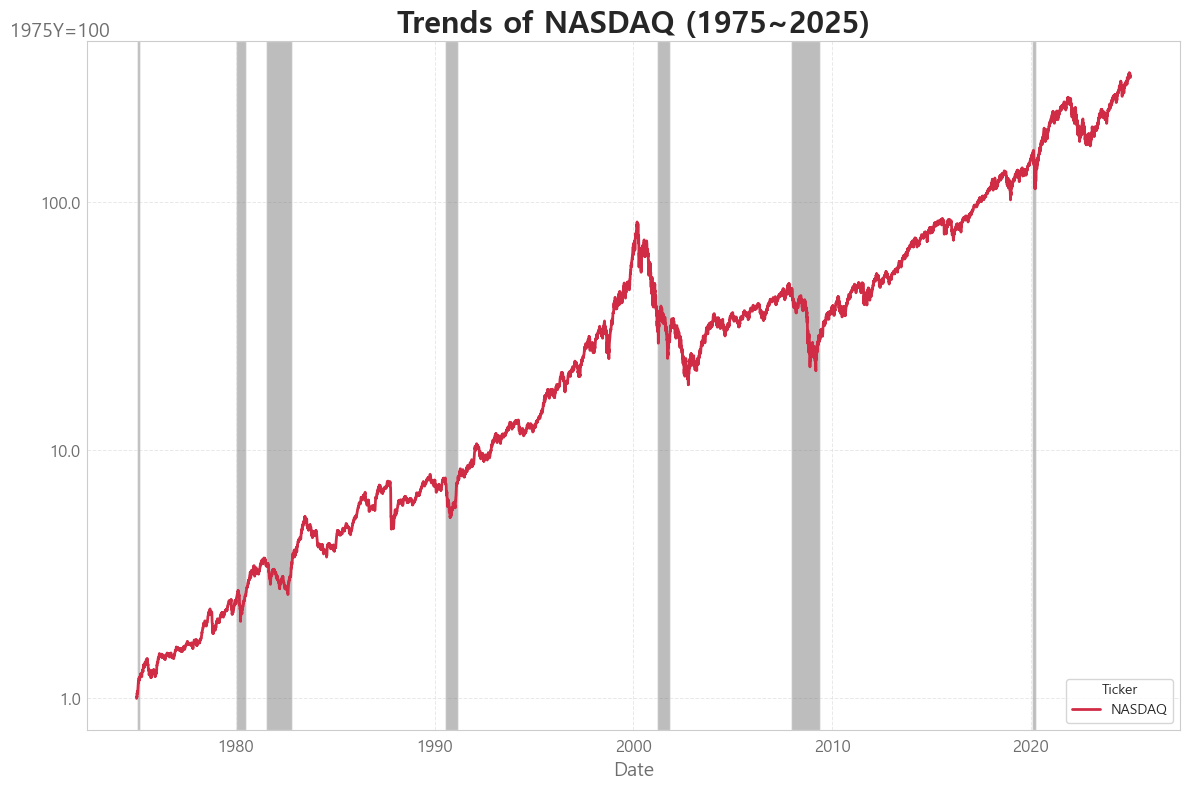

In [35]:
gm.trend_plot(plot_df, ['NASDAQ'], highlight_periods=highlight_periods, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

## Visualization

In [9]:
temp_df = (plot_df["2021":]/plot_df["2021":].iloc[0])

In [10]:
temp_df["2023-02":][temp_df['QQQ'] >= temp_df['QQQ'][:"2023-01"].max()]

,S&P500,DowJones,NASDAQ,Div,DGS10,DGS20,Gold,QQQ,SPY,TQQQ,TLT
Date,,,,,,,,,,,
2023-12-13,1.271963,1.227183,1.160296,1.307559,4.343817,3.016333,1.033622,1.327026,1.328355,1.141411,0.658951
2023-12-14,1.275330,1.232414,1.162469,1.329285,4.214792,2.912560,1.057967,1.325875,1.332619,1.139537,0.676092
2023-12-15,1.275233,1.234294,1.166593,1.326718,4.204040,2.898724,1.053355,1.332284,1.330424,1.153120,0.676843
2023-12-18,1.281007,1.234322,1.173750,1.327268,4.247049,2.926397,1.055866,1.340676,1.337908,1.177241,0.671450
2023-12-19,1.288522,1.242657,1.181500,1.334878,4.225544,2.926397,1.061863,1.347526,1.346044,1.194805,0.675068
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,1.613457,1.422458,1.553105,1.506298,4.958893,3.393957,1.347343,1.732136,1.708329,2.019279,0.619007
2024-12-30,1.596190,1.408612,1.534580,1.493536,4.883758,3.359254,1.341655,1.709098,1.688834,1.938183,0.623982
2024-12-31,1.589351,1.407635,1.520720,1.492635,4.915959,3.373135,1.353491,1.694580,1.682690,1.887379,0.620642


In [11]:
temp_df["2023-02":][temp_df['TQQQ'] >= temp_df['TQQQ'][:"2023-01"].max()]

,S&P500,DowJones,NASDAQ,Div,DGS10,DGS20,Gold,QQQ,SPY,TQQQ,TLT
Date,,,,,,,,,,,
2024-12-04,1.644708,1.489353,1.554136,1.567400,4.497351,3.088570,1.366096,1.731664,1.738796,2.050389,0.665882
2024-12-06,1.645730,1.477061,1.563952,1.561270,4.454417,3.067748,1.358308,1.742320,1.739225,2.085811,0.668218
2024-12-11,1.644087,1.460717,1.577743,1.544391,4.572486,3.157976,1.407083,1.753704,1.738224,2.122658,0.652715
2024-12-12,1.635186,1.452961,1.567344,1.541150,4.636887,3.206560,1.383362,1.742386,1.729268,2.080581,0.644786
2024-12-13,1.635142,1.450113,1.569225,1.537942,4.722755,3.255145,1.367223,1.755723,1.728924,2.125273,0.638202
2024-12-16,1.641355,1.446454,1.588689,1.525084,4.712022,3.248204,1.364866,1.781006,1.736307,2.217749,0.640113
2024-12-17,1.635013,1.437601,1.583584,1.520238,4.722755,3.248204,1.361280,1.773163,1.729153,2.188033,0.641671
2024-12-24,1.632157,1.432543,1.577447,1.515584,4.926692,3.359254,1.348777,1.756664,1.726388,2.109438,0.624479
2024-12-26,1.631494,1.433495,1.576599,1.516460,4.915959,3.352313,1.358410,1.755471,1.726503,2.104906,0.624124


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


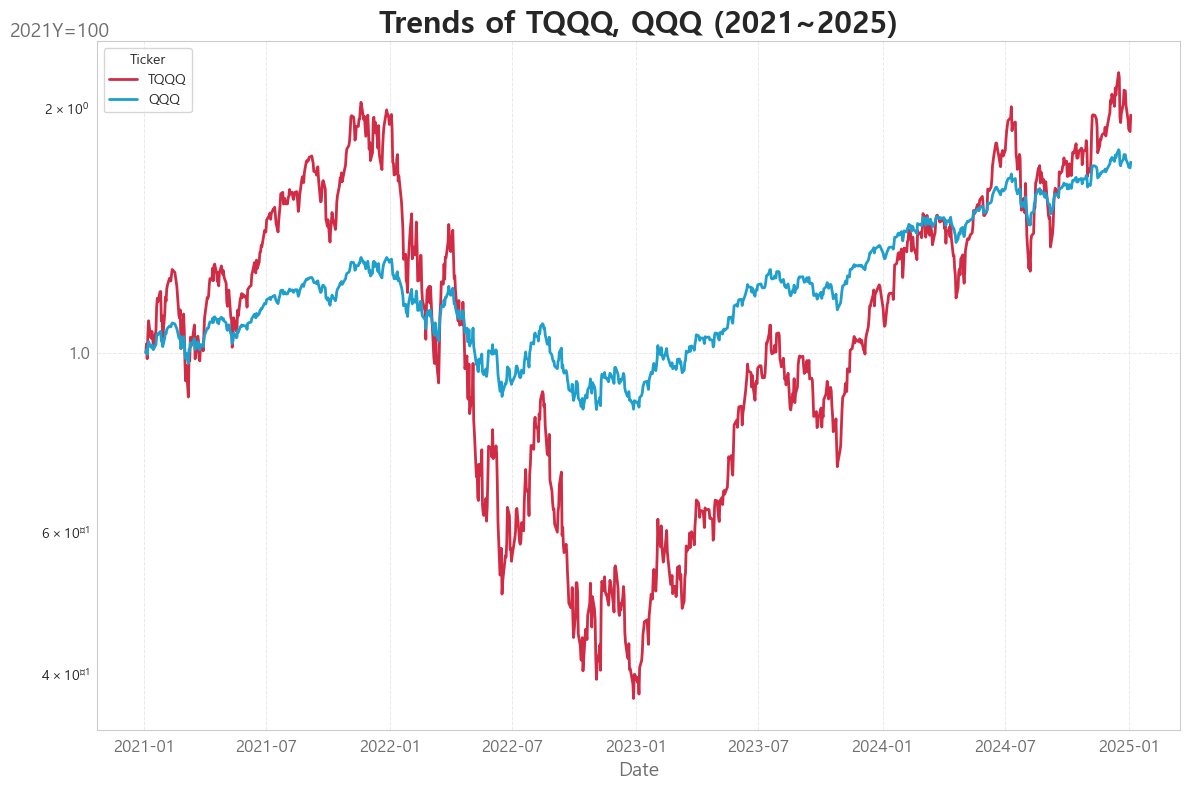

In [12]:
gm.trend_plot(temp_df, assets, highlight_periods=highlight_periods, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

In [42]:
anal_funcs.get_Vol_report(result,'a')

,Return,Volatility,Volatility(Down),Residual,Beta,Sharpe_Ratio,Sortino_Ratio,Trainer_Ratio,Jensen_Alpha,Info_Ratio
Ticker,,,,,,,,,,
QQQ,13.39,6.28,4.70,0.00,1.00,1.81,2.42,11.39,-0.00,NaN
TQQQ,38.43,18.81,11.71,12.62,0.33,1.94,3.11,110.17,32.66,1.98
TLT,1.95,2.90,1.85,6.94,-0.02,-0.02,-0.03,2.05,0.22,-1.65
Gold,5.45,5.33,3.20,8.10,0.04,0.65,1.08,92.93,3.03,-0.98
Portfolio,16.72,6.03,3.68,2.82,0.93,2.44,4.00,15.78,4.10,1.18


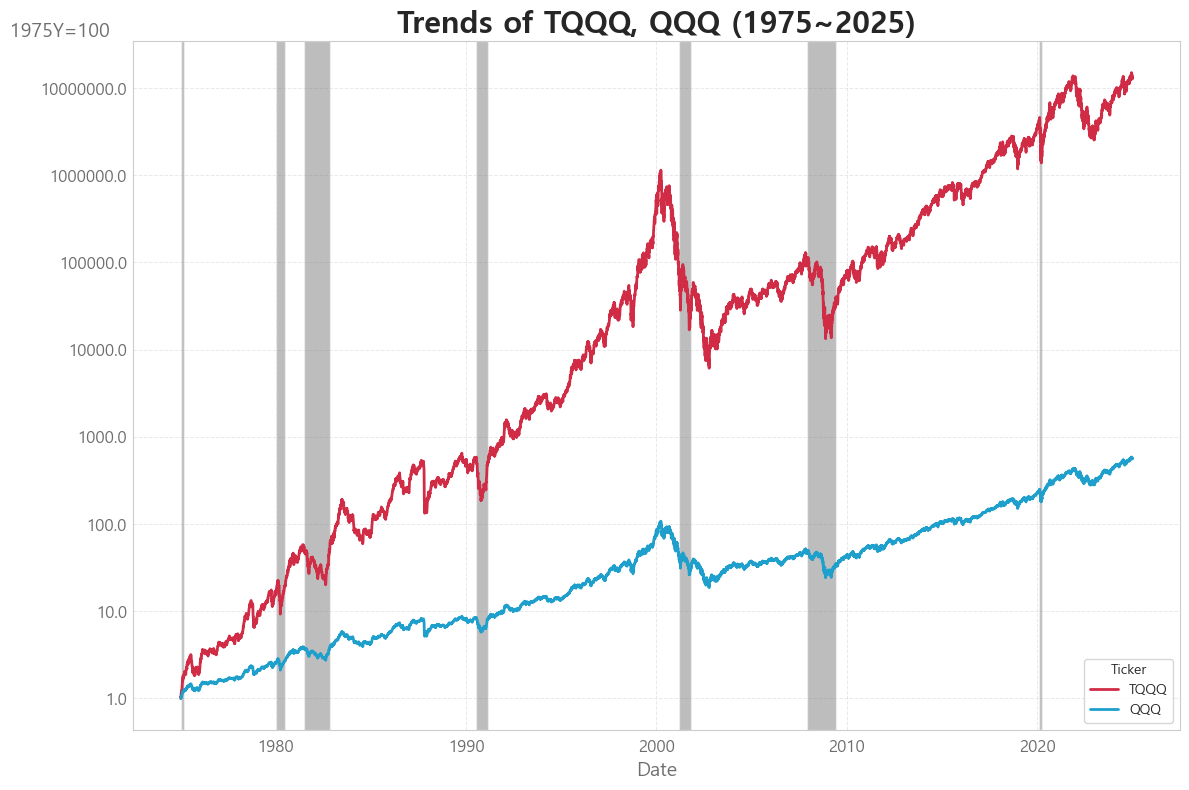

In [38]:
gm.trend_plot(plot_df, assets, highlight_periods=highlight_periods, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

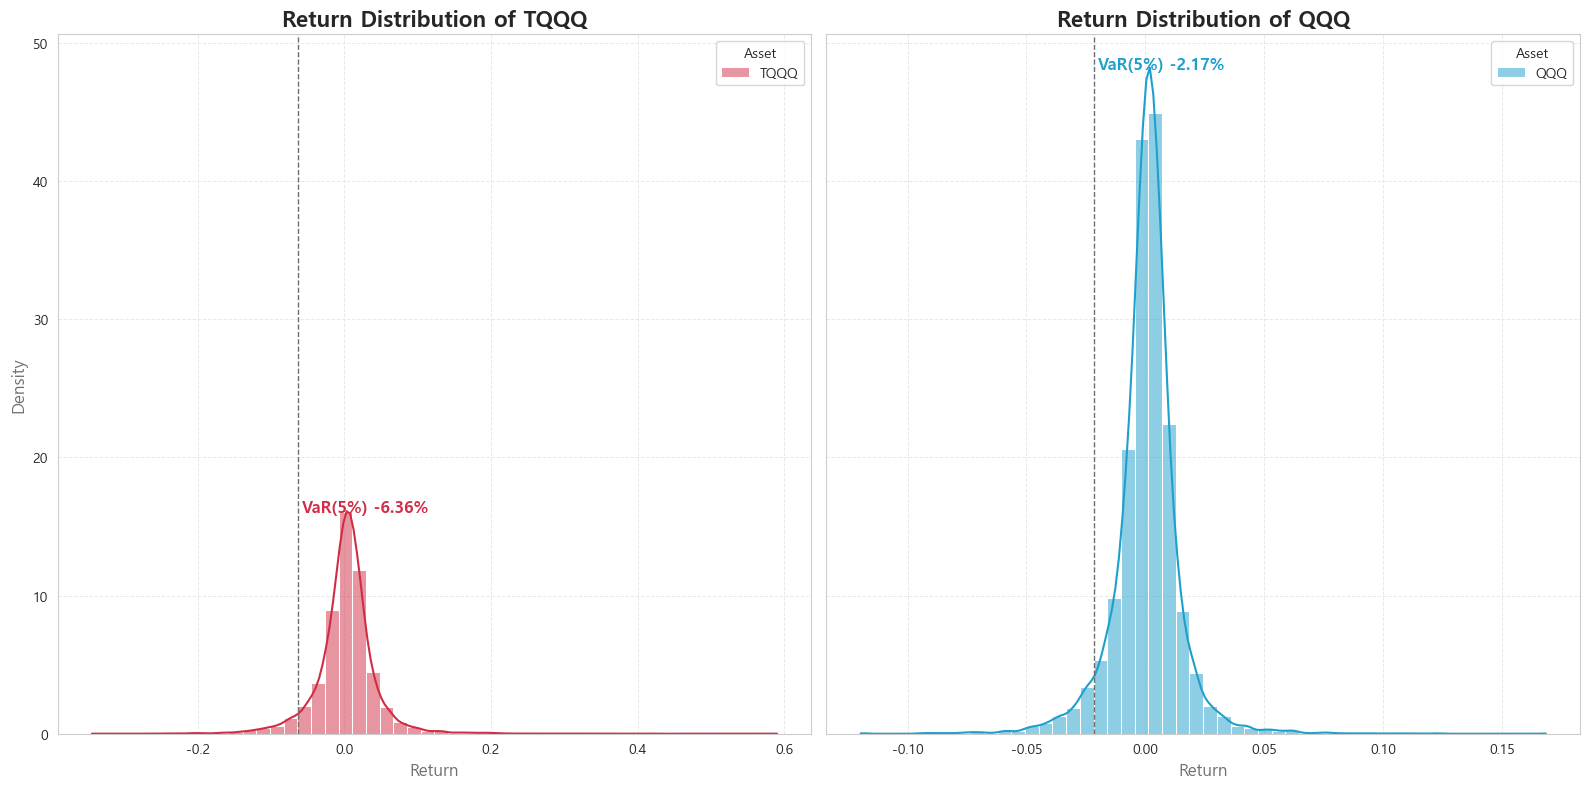

In [14]:
gm.asset_histogram_plot(plot_df.pct_change(), assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

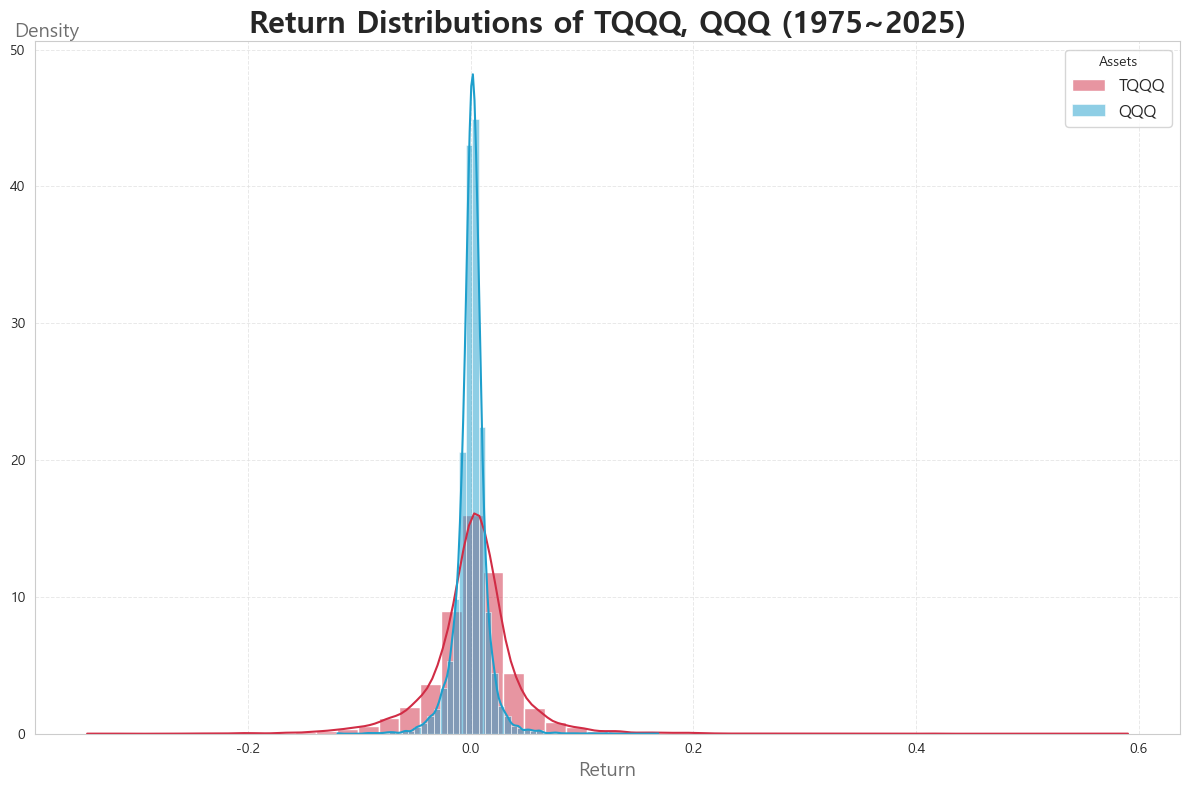

In [15]:
gm.asset_histogram_merged_plot(plot_df.pct_change(), assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

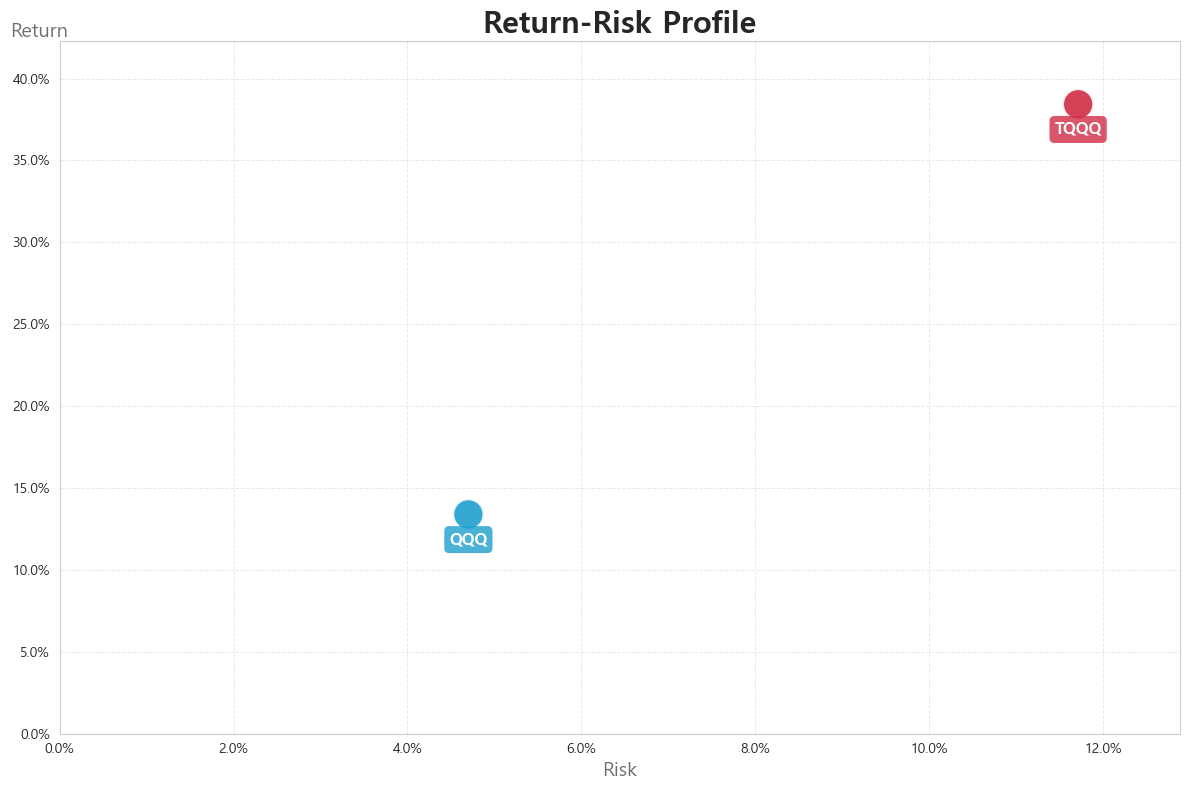

In [16]:
return_risk_df = anal_funcs.get_Vol_report(plot_df[assets], method='a', rf=0)
# gm.return_risk_profile_plot(return_risk_df, assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])
gm.return_risk_profile_plot(return_risk_df, assets, colors=[mycolors['color_norm'], mycolors['color_cont']])

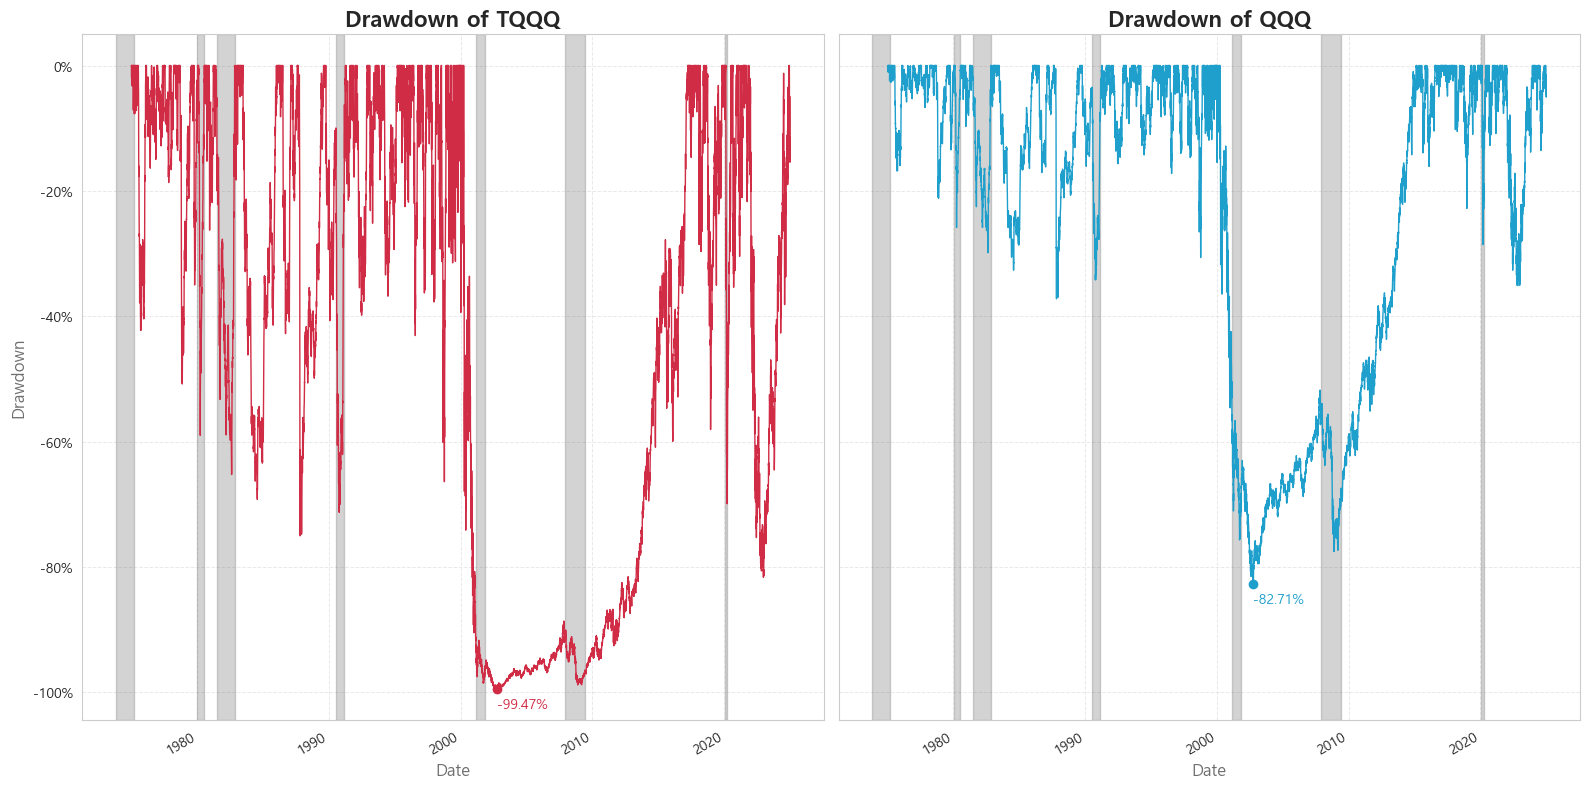

In [17]:
gm.drawdown_plot(plot_df, assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']], highlight_periods=highlight_periods)

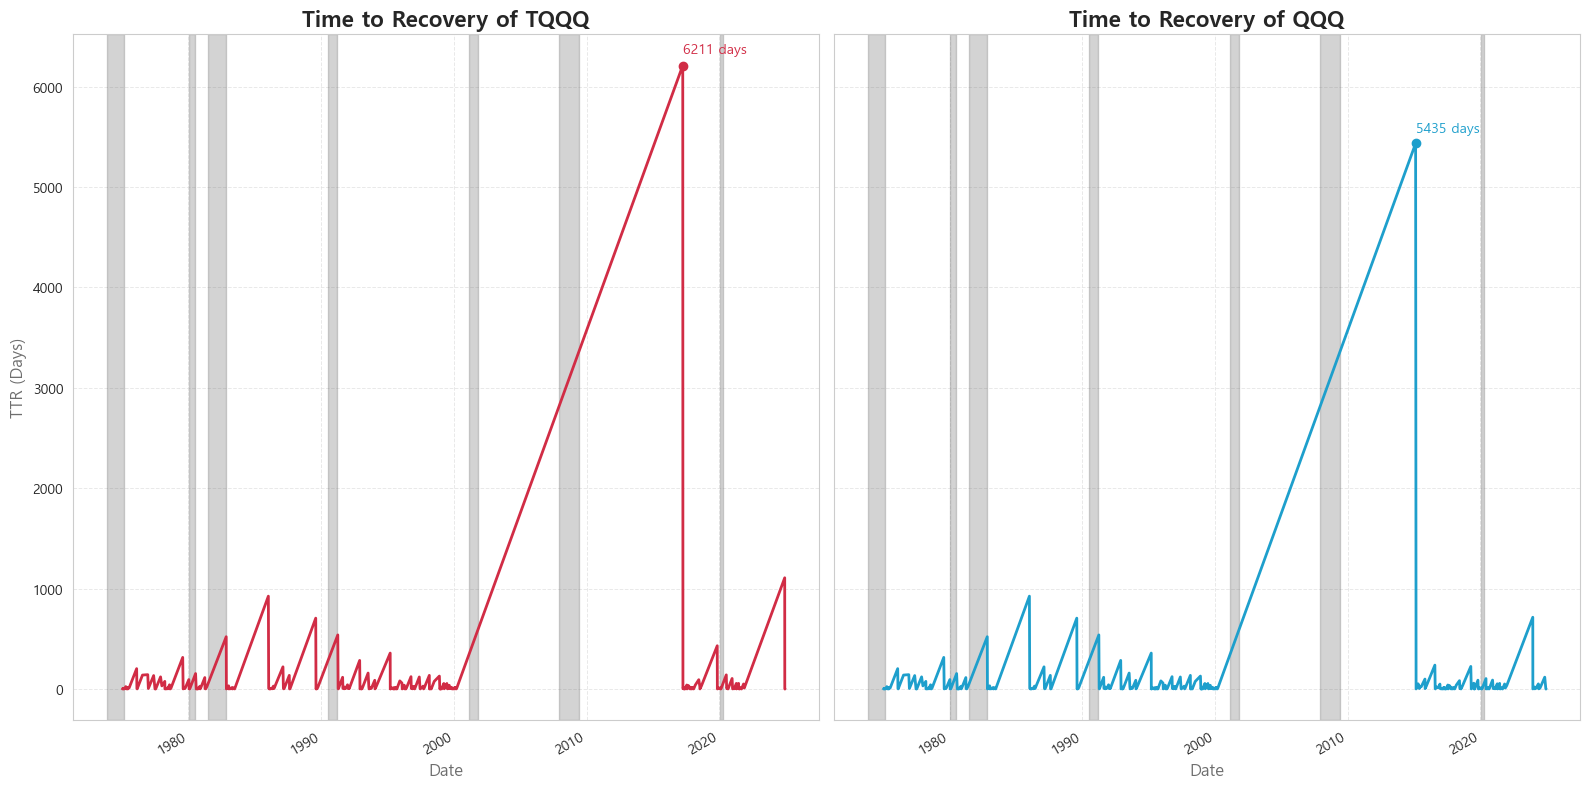

In [18]:
ttr_df = myfuncs.get_ttr_df(plot_df, assets)

gm.ttr_plot(ttr_df, assets, highlight_periods=highlight_periods, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

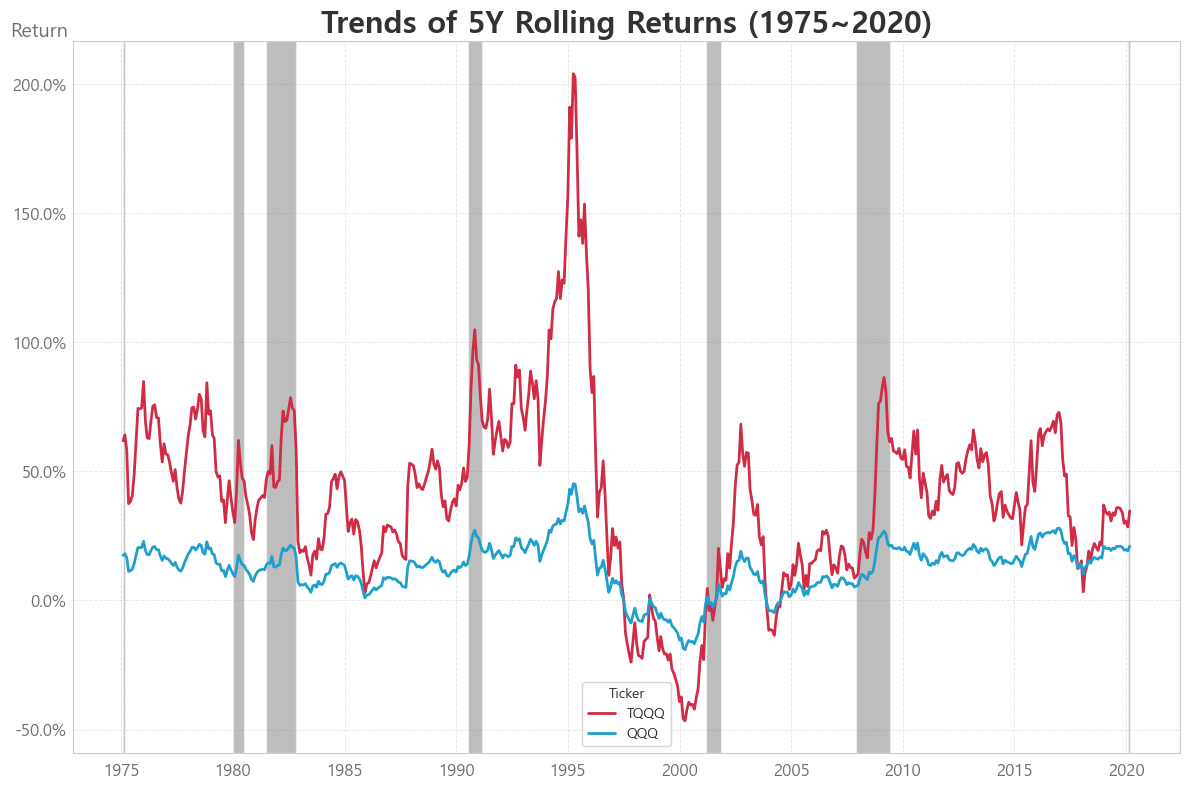

In [19]:
rr_df = myfuncs.get_rr_df(plot_df, assets)
gm.rr_trend_plot(rr_df, assets, highlight_periods=highlight_periods, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

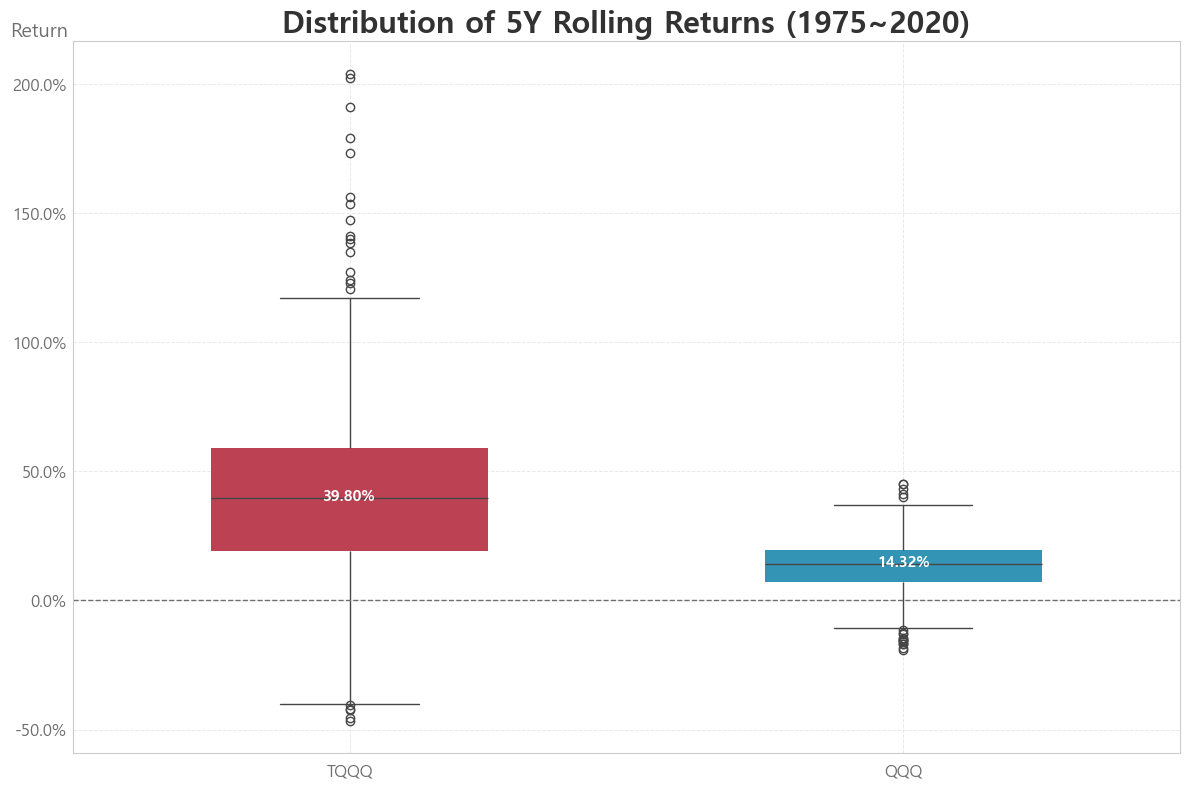

In [20]:
gm.rr_box_plot(rr_df, assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

In [21]:
assets_port = assets + ['TLT', 'Gold']
assets_port = ['TQQQ','QQQ']

In [22]:
def corr_plot(corr_df, cmap=None):
    # cmap이 None이면 기본 컬러맵 설정
    if cmap is None:
        custom_colors = ["#F7FBFF", "#6BAED6", "#08306B"]
        cmap = LinearSegmentedColormap.from_list("custom", custom_colors)

    # 히트맵 시각화
    plt.figure(figsize=figsize)
    sns.heatmap(corr_df, annot=True, cmap=cmap, fmt='.2f',
                linewidths=0.5, cbar_kws={"shrink": .8}, cbar=False, annot_kws={"size": 40})
    plt.title('Asset Correlations', fontsize=40, fontweight="bold", color=mycolors['color_basic'])
    plt.ylabel("Assets", fontsize=40, labelpad=-50, color=mycolors['color_around'], loc="top", rotation=0)
    plt.xlabel("")
    plt.yticks(rotation=0, fontsize=40, color=mycolors['color_around'])
    plt.xticks(rotation=0, fontsize=40, color=mycolors['color_around'])
    plt.tight_layout()
    plt.show()

In [23]:
# corr_df = plot_df.pct_change()[assets_port].corr()
# corr_plot(corr_df, cmap=custom_cmap)

## Optimization

In [24]:
assets_port = ['QQQ', 'TQQQ', 'TLT', 'Gold']

In [25]:
df_imp_m = plot_df[assets_port].resample('M').last()

In [26]:
allocator = portfolio_obtimizer.PortfolioAllocator()

cal_optimal => eg. process, obtimal, min_risk = cal_optimal(df)
eg. process, obtimal, min_risk = cal_optimal(df)


In [21]:
process, obtimal, min_risk = allocator.cal_optimal(df_imp_m, unit='monthly', rebalancing='m', d=10, min_edge=0)

총 286번 시행 예정
1번째 시행 중


100번째 시행 중
200번째 시행 중


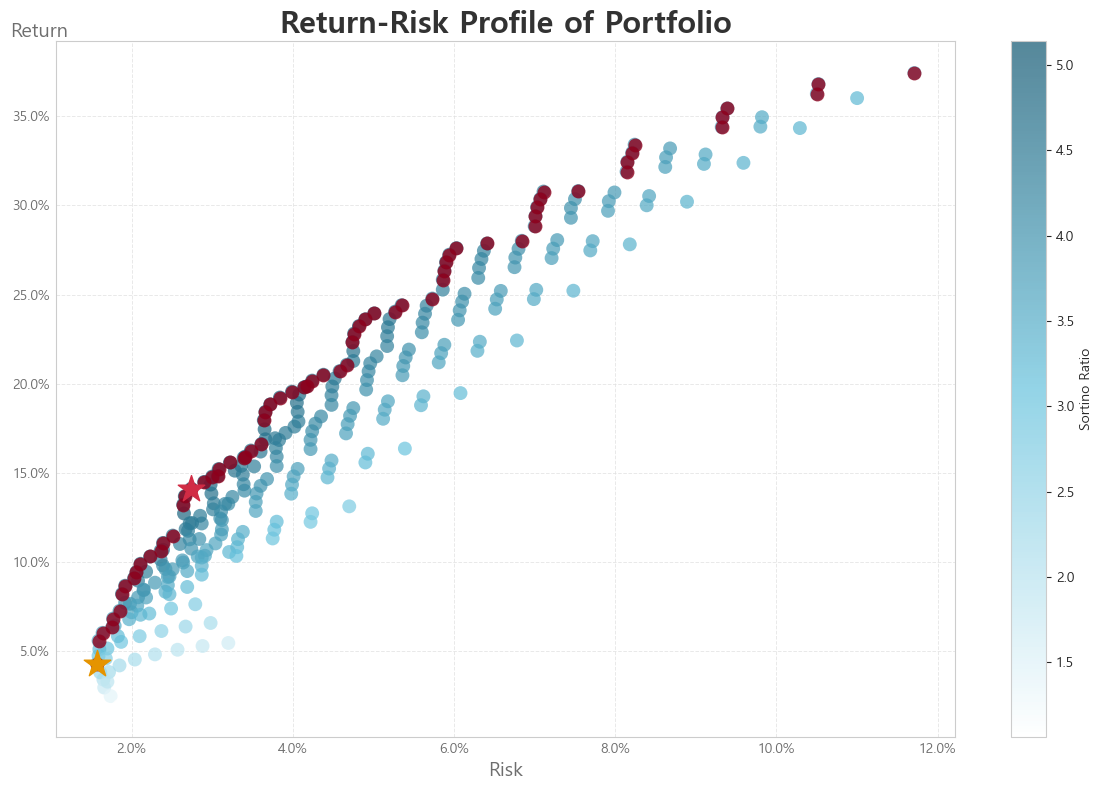

In [22]:
gm.portfilio_return_risk_profile_plot(process, obtimal, min_risk, cmap=custom_cmap)
# gm.portfilio_return_risk_profile_plot(process, min_risk, min_risk, cmap=custom_cmap)

In [27]:
## ratio 임의 조정시
ratio = [0.0, 0.3, 0.35, 0.35]
result = allocator.cal_rebalancing(plot_df[df_imp_m.columns], ratio=ratio, rebalancing='m', unit='daily')
result.rename(columns={'strategy':'Portfolio'}, inplace=True)
result = result/result.iloc[0]*100

In [28]:
port_assets = ['Portfolio'] + assets
port_assets_sp = ['Portfolio', 'QQQ']

In [29]:
# ## ratio 임의 조정시
# ratio = [0, .7, 0.15, 0.15]
# result = allocator.cal_rebalancing(plot_df[df_imp_m.columns], ratio=ratio, rebalancing=None, unit='daily')
# result.rename(columns={'strategy':'QQQ+TLT+Gold'}, inplace=True)
# res1 = result/result.iloc[0]*100

# ## ratio 임의 조정시
# ratio = [0.8, .2, 0, 0]
# result = allocator.cal_rebalancing(plot_df[df_imp_m.columns], ratio=ratio, rebalancing=None, unit='daily')
# result.rename(columns={'strategy':'SCHD+QQQ'}, inplace=True)
# res2 = result/result.iloc[0]*100

# res2['QQQ+TLT+Gold'] = res1['QQQ+TLT+Gold']
# result = res2

# last_cols = ['QQQ+TLT+Gold', 'SCHD+QQQ', 'SCHD' ,'QQQ']
# last_cols_sp = ['QQQ+TLT+Gold', 'SCHD+QQQ']

In [33]:
anal_funcs.get_Vol_report(result, method='a', rf=0)

,Return,Volatility,Volatility(Down),Residual,Beta,Sharpe_Ratio,Sortino_Ratio,Trainer_Ratio,Jensen_Alpha,Info_Ratio
Ticker,,,,,,,,,,
QQQ,13.39,6.28,4.70,0.00,1.00,2.13,2.85,13.39,-0.00,NaN
TQQQ,38.43,18.81,11.71,12.62,0.33,2.04,3.28,116.22,34.00,1.98
TLT,1.95,2.90,1.85,6.94,-0.02,0.67,1.05,-83.21,2.27,-1.65
Gold,5.45,5.33,3.20,8.10,0.04,1.02,1.70,146.79,4.95,-0.98
Portfolio,16.72,6.03,3.68,2.82,0.93,2.77,4.54,17.93,4.23,1.18


In [31]:
result

,QQQ,TQQQ,TLT,Gold,Portfolio
Date,,,,,
1975-01-02,100.000000,1.000000e+02,100.000000,100.000000,100.000000
1975-01-03,100.912497,1.027445e+02,100.105831,100.000000,100.860396
1975-01-06,101.790901,1.054333e+02,100.265291,99.828277,101.662750
1975-01-07,102.049312,1.062331e+02,100.265291,99.255867,101.702349
1975-01-08,101.377493,1.041621e+02,100.425613,101.545507,101.938531
...,...,...,...,...,...
2024-12-27,57085.402082,1.369357e+09,264.618206,1435.973007,245562.656287
2024-12-30,56326.170141,1.314363e+09,266.744887,1429.911182,242747.109517
2024-12-31,55847.693796,1.279910e+09,265.316978,1442.526284,241122.164820


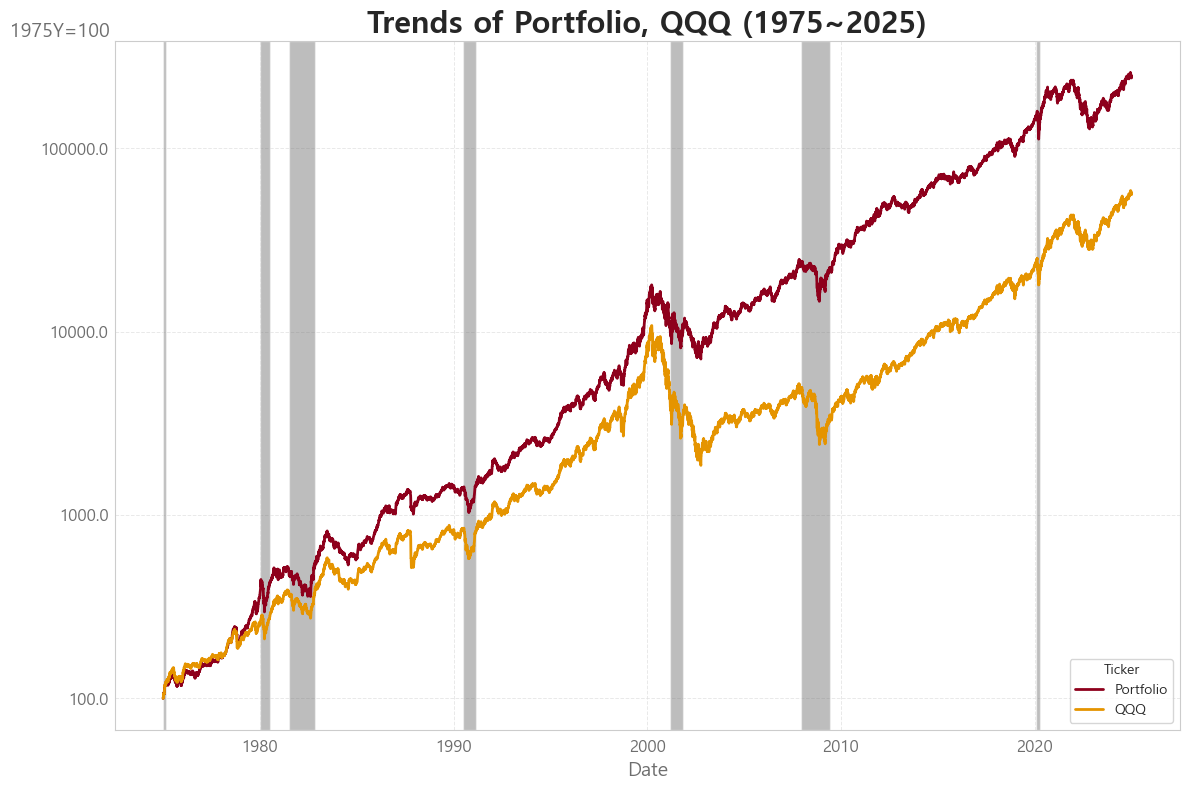

In [30]:
gm.trend_plot(result, port_assets_sp, highlight_periods=highlight_periods, colors=[mycolors['color_norm2'], mycolors['color_sub']])

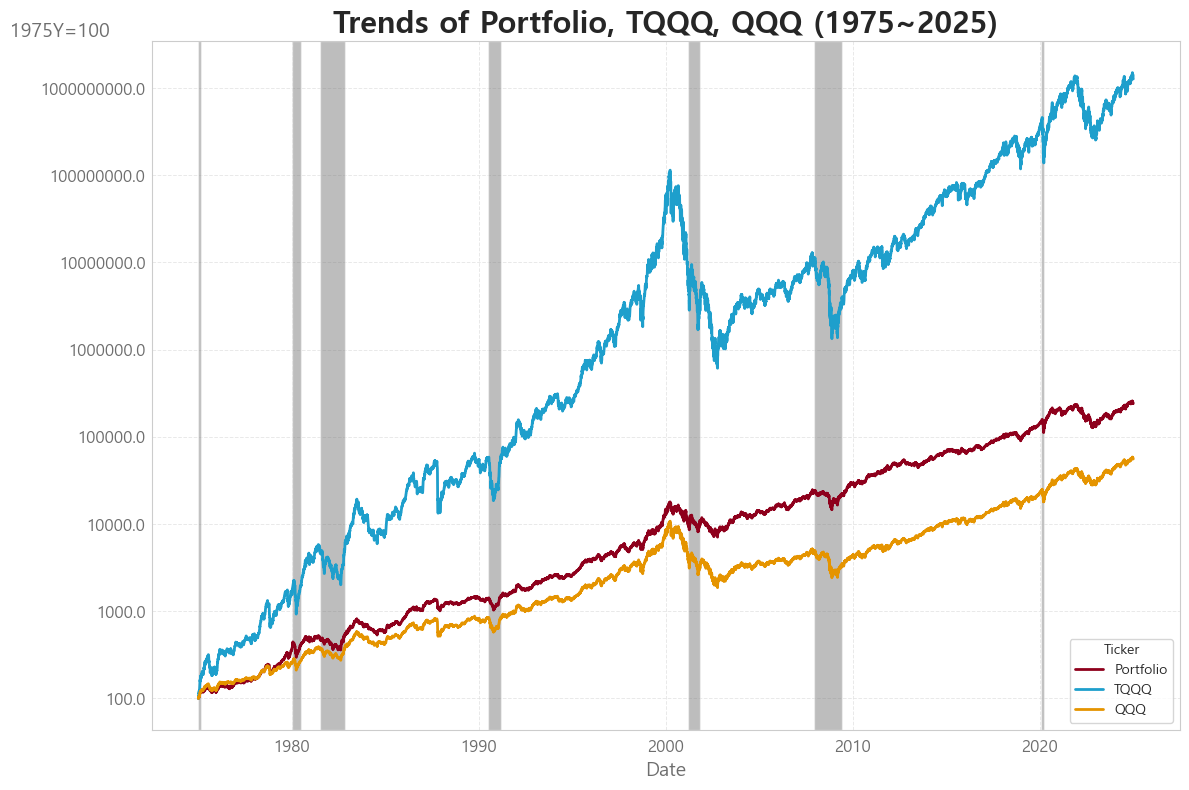

In [26]:
gm.trend_plot(result, port_assets, highlight_periods=highlight_periods, colors=[mycolors['color_norm2'], mycolors['color_cont'], mycolors['color_sub']])

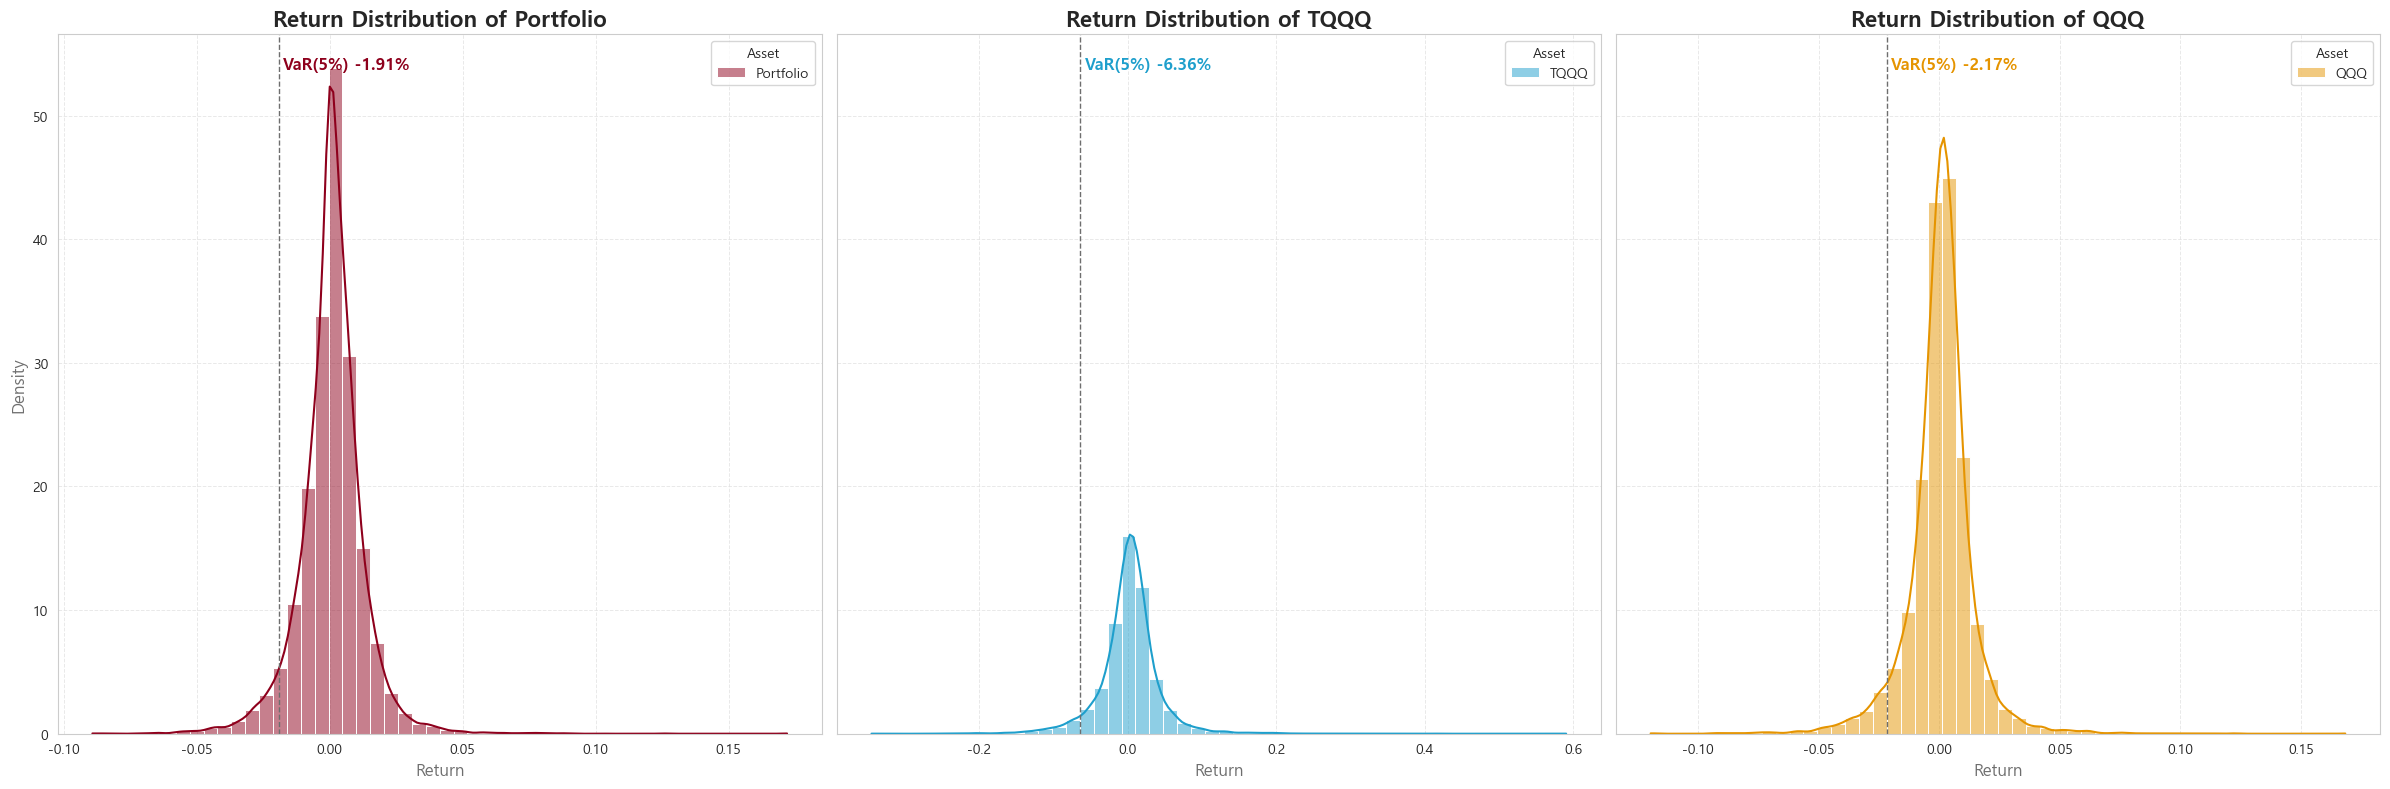

In [70]:
gm.asset_histogram_plot(result.pct_change(), port_assets, colors=[mycolors['color_norm2'], mycolors['color_cont'], mycolors['color_sub']])

In [71]:
## gm.asset_histogram_merged_plot(result.pct_change(), port_assets, colors=[mycolors['color_norm2'], mycolors['color_cont'], mycolors['color_sub']])

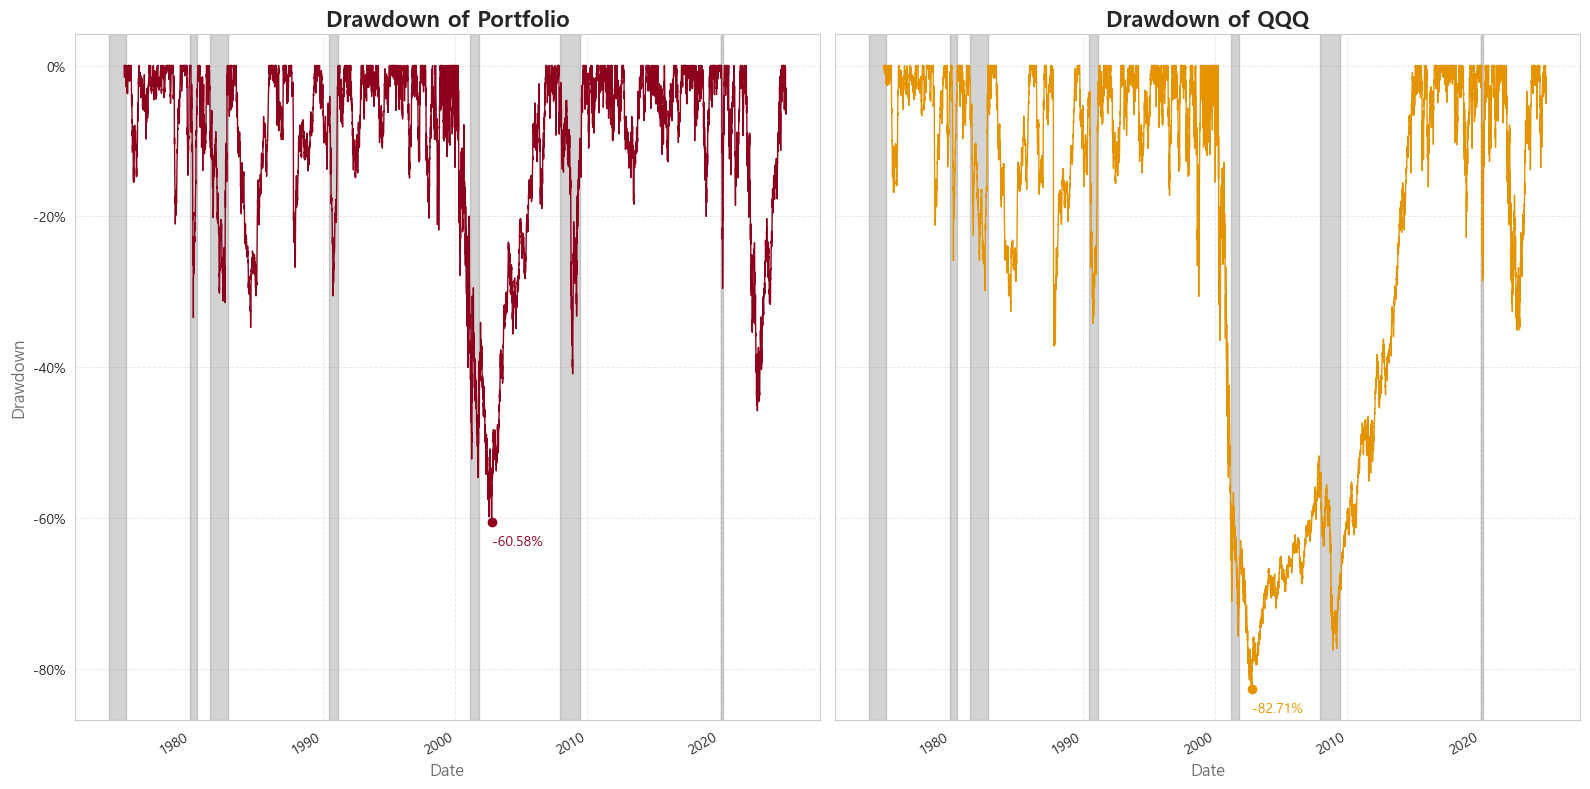

In [48]:
gm.drawdown_plot(result, ['Portfolio', 'QQQ'], highlight_periods=highlight_periods, colors=[mycolors['color_norm2'], mycolors['color_sub']])

In [44]:
result

,QQQ,TQQQ,TLT,Gold,Portfolio
Date,,,,,
1975-01-02,100.000000,1.000000e+02,100.000000,100.000000,100.000000
1975-01-03,100.912497,1.027445e+02,100.105831,100.000000,100.860396
1975-01-06,101.790901,1.054333e+02,100.265291,99.828277,101.662750
1975-01-07,102.049312,1.062331e+02,100.265291,99.255867,101.702349
1975-01-08,101.377493,1.041621e+02,100.425613,101.545507,101.938531
...,...,...,...,...,...
2024-12-27,57085.402082,1.369357e+09,264.618206,1435.973007,245562.656287
2024-12-30,56326.170141,1.314363e+09,266.744887,1429.911182,242747.109517
2024-12-31,55847.693796,1.279910e+09,265.316978,1442.526284,241122.164820


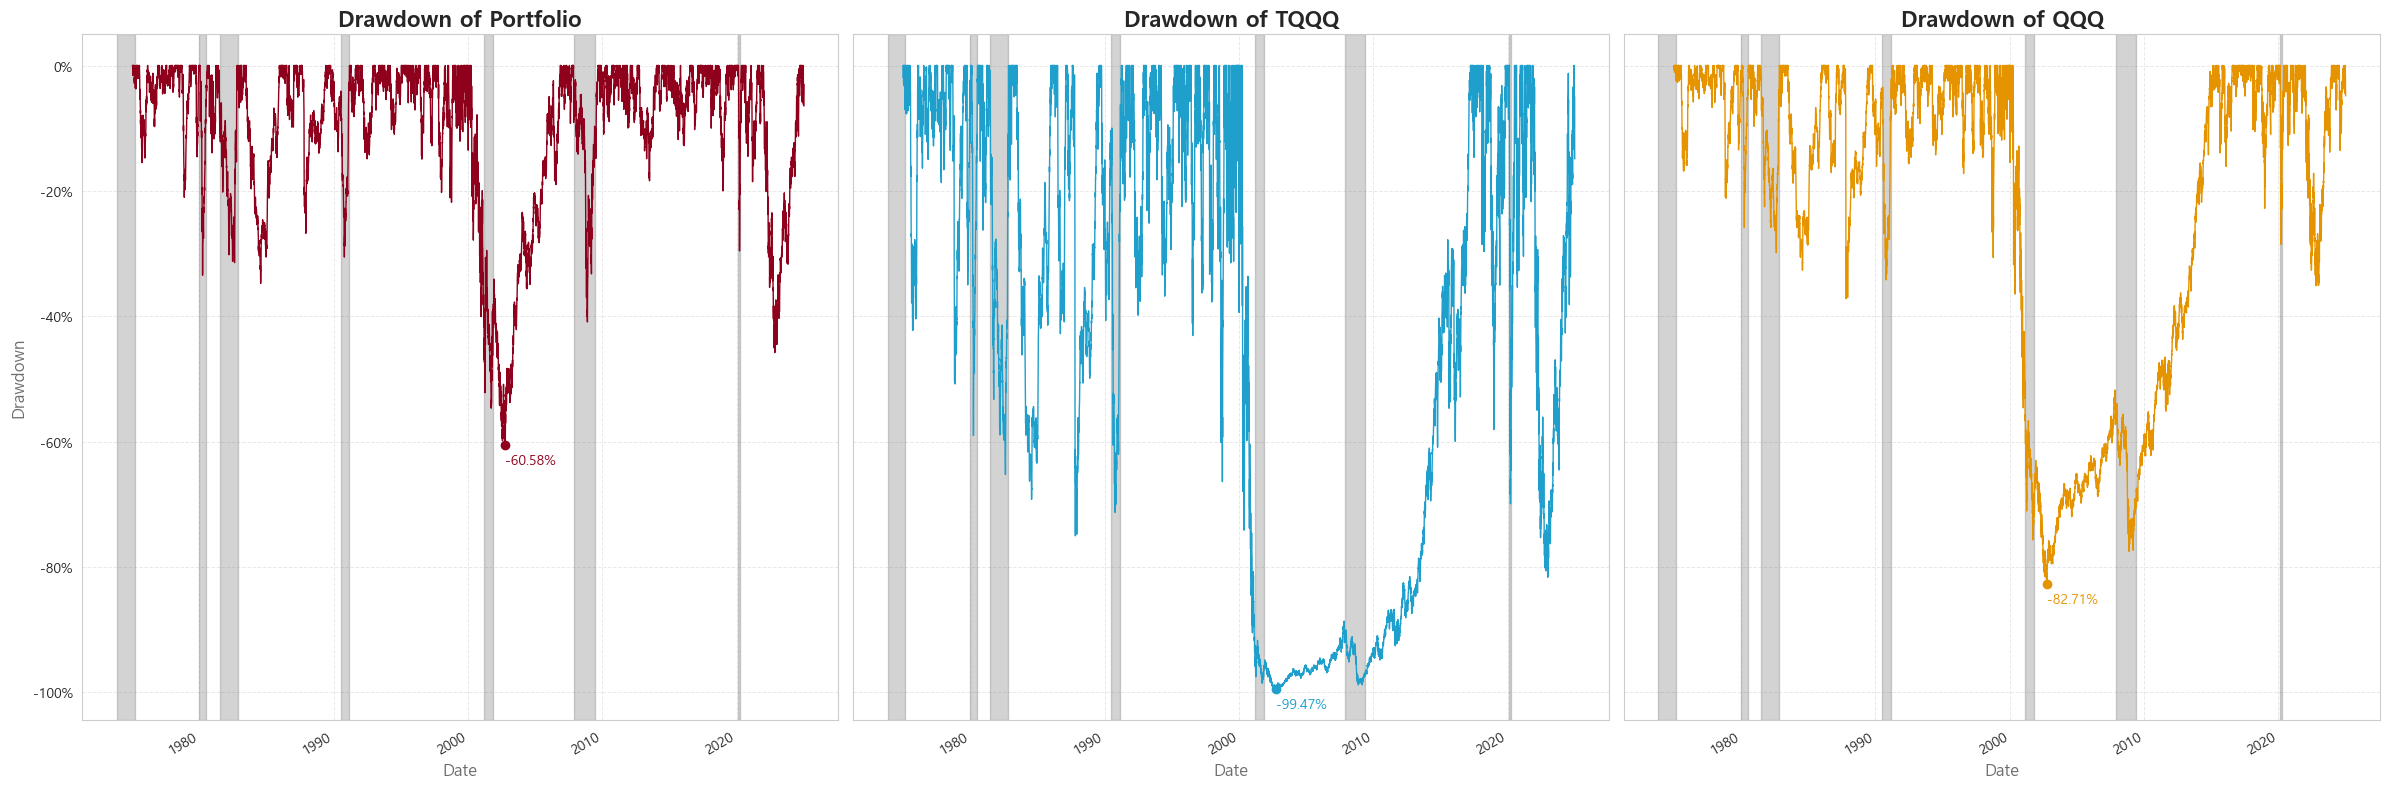

In [72]:
gm.drawdown_plot(result, port_assets, highlight_periods=highlight_periods, colors=[mycolors['color_norm2'], mycolors['color_cont'], mycolors['color_sub']])

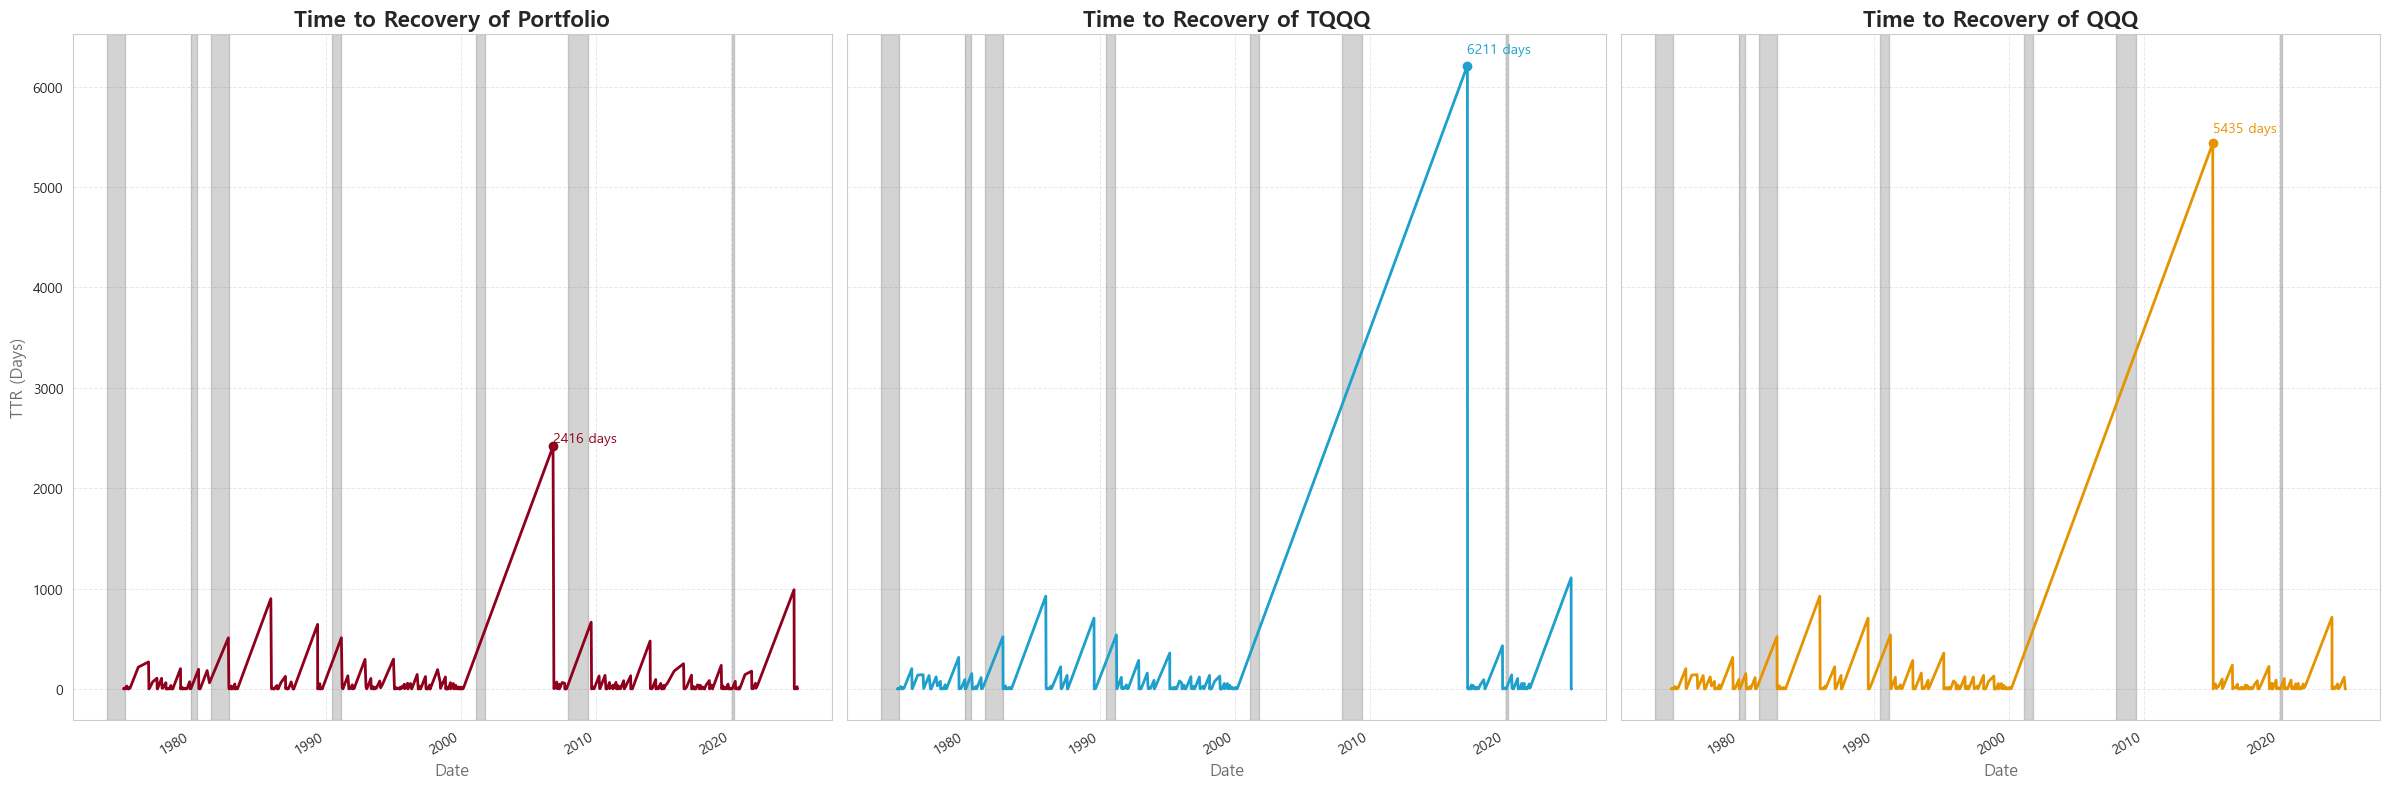

In [43]:
ttr_df = myfuncs.get_ttr_df(result, port_assets)
gm.ttr_plot(ttr_df, port_assets, highlight_periods=highlight_periods, colors=[mycolors['color_norm2'], mycolors['color_cont'], mycolors['color_sub']])

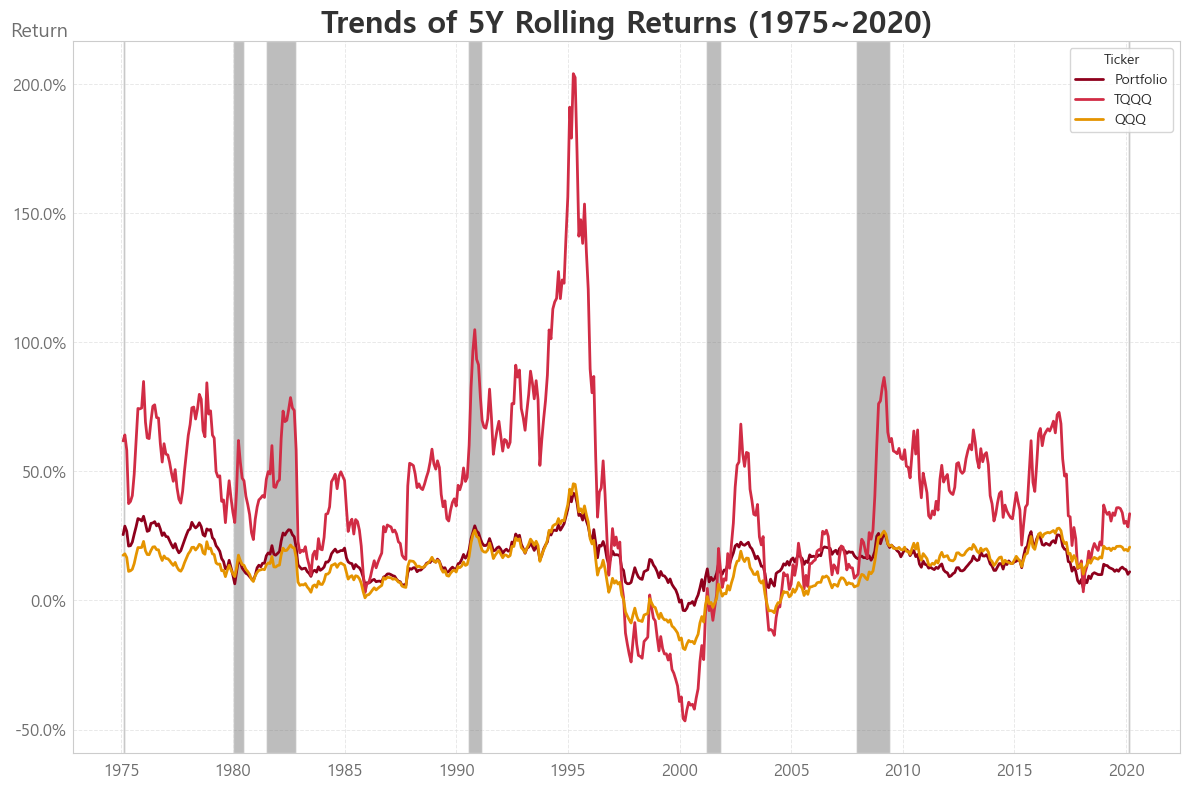

In [54]:
rr_df = myfuncs.get_rr_df(result, port_assets)
gm.rr_trend_plot(rr_df, port_assets, highlight_periods=highlight_periods, colors=[mycolors['color_norm2'], mycolors['color_norm'], mycolors['color_sub']])

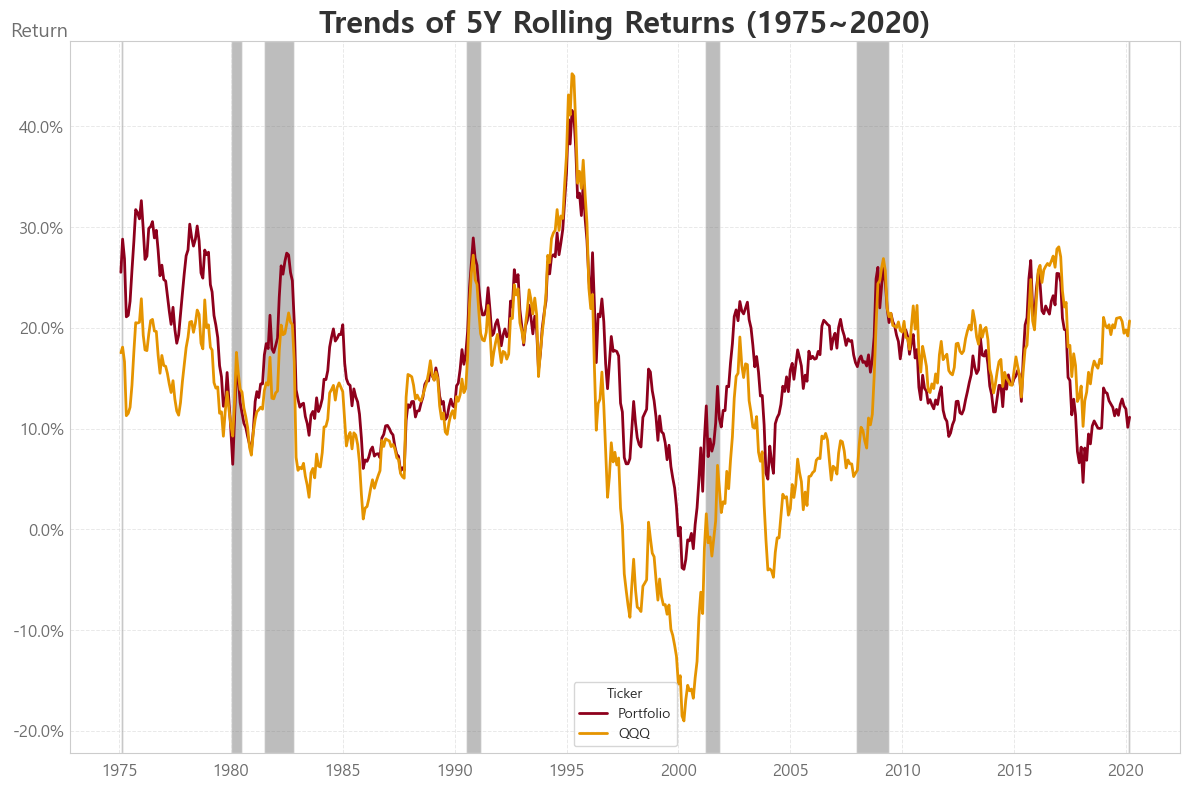

In [74]:
rr_df = myfuncs.get_rr_df(result, port_assets)
gm.rr_trend_plot(rr_df, port_assets_sp, highlight_periods=highlight_periods, colors=[mycolors['color_norm2'], mycolors['color_sub']])

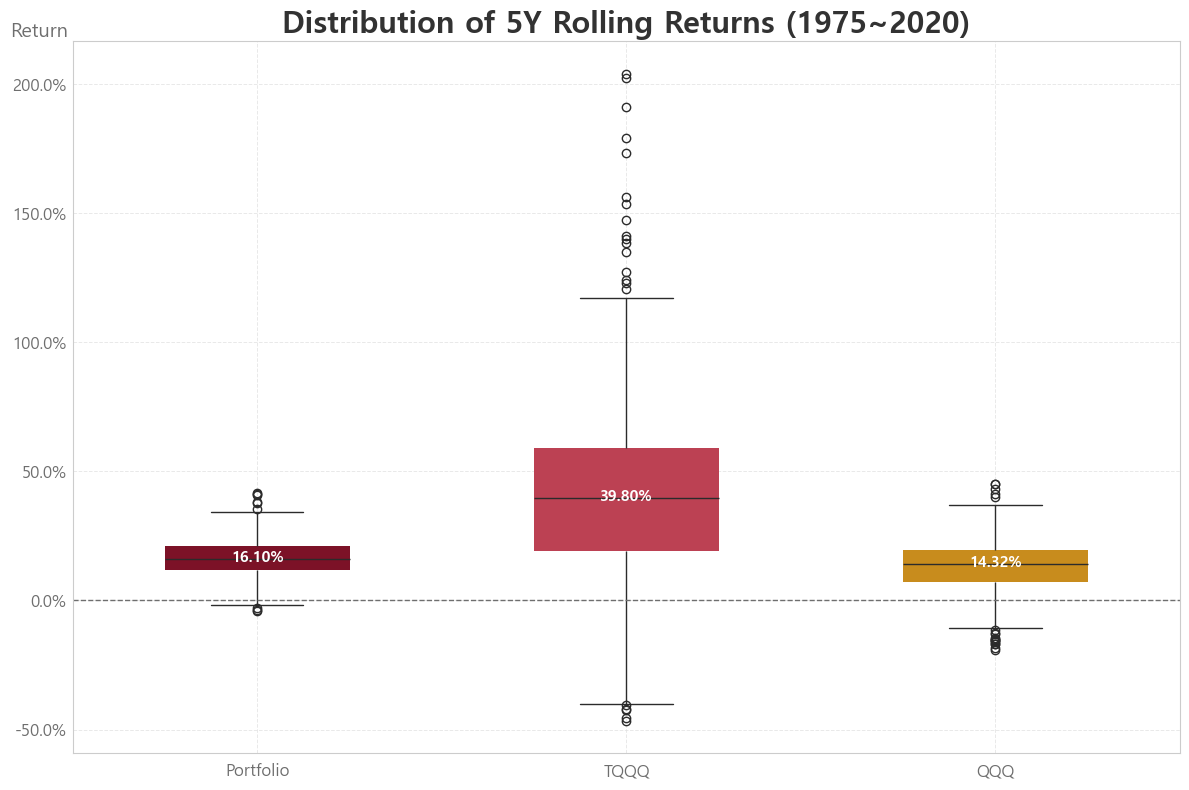

In [75]:
gm.rr_box_plot(rr_df, port_assets, colors=[mycolors['color_norm2'], mycolors['color_norm'], mycolors['color_sub']])

In [56]:
bm_ratios = {'0:5:5': [0, 0, 0.5, 0.5], 
             '10:45:45': [0, 0.1, 0.45, 0.45], '20:40:40': [0, 0.2, 0.4, 0.4],
             '30:35:35': [0, 0.3, 0.35, 0.35], '40:30:30': [0, 0.4, 0.3, 0.3],
             '50:25:25': [0, 0.5, 0.25, 0.25], '60:20:20': [0, 0.6, 0.2, 0.2],
             '70:15:15': [0, 0.7, 0.15, 0.15], '80:10:10': [0, 0.8, 0.1, 0.1],
             '90:5:5': [0, 0.9, 0.05, 0.05]}


ls = {}
for _key in bm_ratios.keys():
    ratio = bm_ratios[_key]
    result = allocator.cal_rebalancing(df_imp_m[df_imp_m.columns], ratio=ratio, rebalancing='m', unit='monthly')
    result.rename(columns={'strategy':'Portfolio'}, inplace=True)
    result = result/result.iloc[0]*100
    ls[_key] = result['Portfolio']

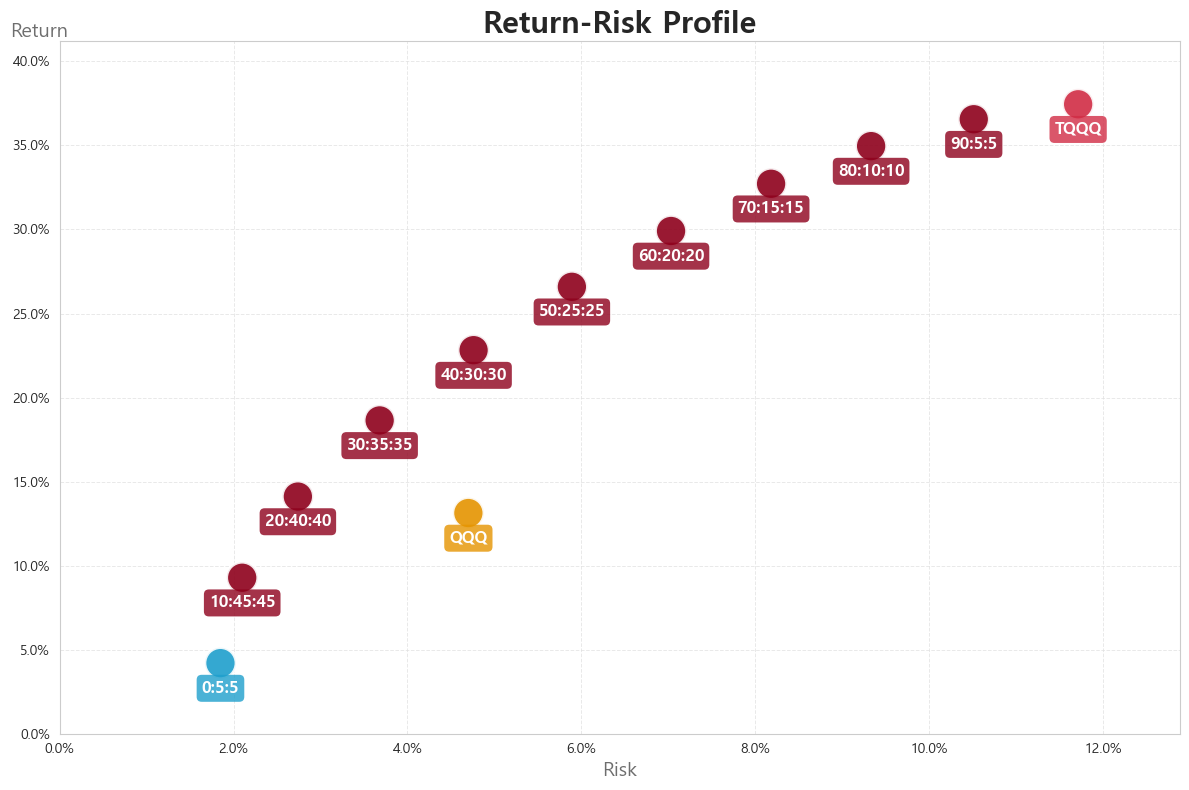

In [57]:
rr_res = pd.DataFrame(ls)
rr_res['QQQ'] = result['QQQ']
rr_res['TQQQ'] = result['TQQQ']


return_risk_df = anal_funcs.get_Vol_report(rr_res, unit='monthly', method='a', rf=0)

gm.return_risk_profile_plot(
    return_risk_df,
    list(return_risk_df.index),
    colors=[
        mycolors["color_cont"],
        mycolors["color_norm2"],
        mycolors["color_norm2"],
        mycolors["color_norm2"],
        mycolors["color_norm2"],
        mycolors["color_norm2"],
        mycolors["color_norm2"],
        mycolors["color_norm2"],
        mycolors["color_norm2"],
        mycolors["color_norm2"],
        mycolors["color_sub"],
        mycolors["color_norm"],
    ],
)

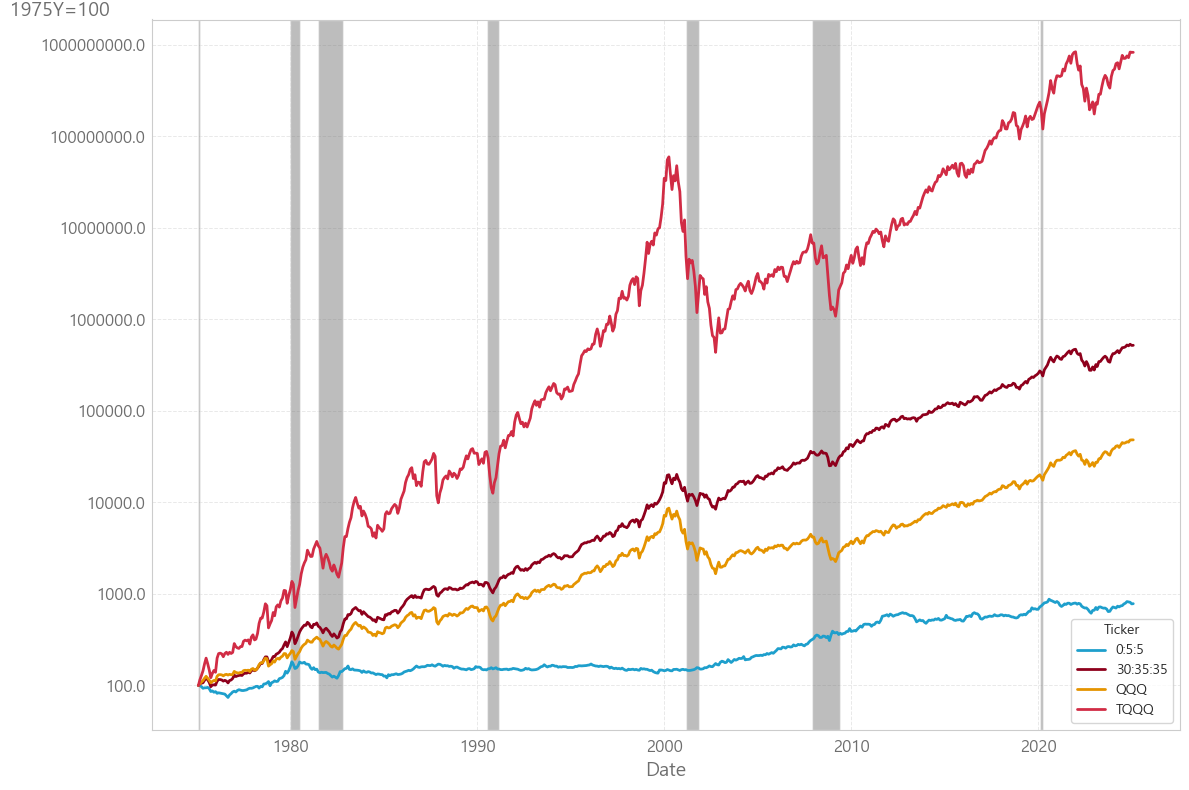

In [58]:
target = '30:35:35'

gm.trend_plot(
    rr_res,
    ['0:5:5', target, 'QQQ', 'TQQQ'],
    highlight_periods=highlight_periods,
    colors=[
        mycolors["color_cont"],
        mycolors["color_norm2"],
        mycolors["color_sub"],
        mycolors["color_norm"],
    ], title=False
)

In [265]:
rr_res

,0:5:5,10:45:45,20:40:40,30:35:35,40:30:30,50:25:25,60:20:20,70:15:15,80:10:10,90:5:5,QQQ,TQQQ
Date,,,,,,,,,,,,
1975-01-31,100.000000,100.000000,100.000000,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,100.000000,1.000000e+02
1975-02-28,99.359829,100.932354,102.504879,104.077403,1.056499e+02,1.072225e+02,1.087950e+02,1.103675e+02,1.119400e+02,1.135126e+02,104.826564,1.150851e+02
1975-03-31,97.069897,100.028979,103.032396,106.080147,1.091722e+02,1.123087e+02,1.154894e+02,1.187145e+02,1.219839e+02,1.252977e+02,108.820965,1.286558e+02
1975-04-30,93.150240,97.628028,102.246736,107.008541,1.119156e+02,1.169702e+02,1.221743e+02,1.275303e+02,1.330403e+02,1.387064e+02,113.152828,1.445309e+02
1975-05-31,94.331458,100.618308,107.213663,114.127434,1.213697e+02,1.289506e+02,1.368807e+02,1.451704e+02,1.538303e+02,1.628715e+02,120.026115,1.723048e+02
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-30,825.389251,8837.419528,75932.056829,525232.552496,2.928362e+06,1.314861e+07,4.740230e+07,1.364502e+08,3.109302e+08,5.538476e+08,46019.973566,7.572796e+08
2024-10-31,817.145234,8720.916608,74688.457681,514952.351709,2.861691e+06,1.280724e+07,4.602017e+07,1.320357e+08,2.998775e+08,5.323904e+08,45622.072006,7.255217e+08
2024-11-30,811.566823,8798.431208,76526.048977,535714.447815,3.022042e+06,1.372614e+07,5.004527e+07,1.456590e+08,3.355311e+08,6.040549e+08,48063.230268,8.345850e+08


In [376]:
rr_df['Portfolio'].describe()

count    253.000000
mean      10.930173
std        4.497749
min       -1.963317
25%        7.355241
50%       11.277106
75%       13.593515
max       24.057869
Name: Portfolio, dtype: float64

In [377]:
rr_df['SCHD'].describe()

count    253.000000
mean      10.644312
std        4.034407
min       -1.476119
25%        8.486104
50%       10.770841
75%       13.374409
max       23.267830
Name: SCHD, dtype: float64